# **1. Importar Librerías**

___

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from google.colab import drive
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# **2. Exploración de Datos**

___

## A. Cargar Imágenes

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Datasets/Malaria/images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Datasets/Malaria/images


Revisar la cantidad de imágenes

In [ ]:
image_files = [file for file in os.listdir() if file.endswith(('.jpg'))]
print("Hay {} imágenes en total.".format(len(image_files)))

Hay 3925 imágenes en total.


## B. Cargar Datasets

In [ ]:
df = pd.read_csv("/content/Train.csv", sep = ",")
test_data = pd.read_csv("/content/Test.csv", sep = ",")

In [ ]:
df.head(10)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0
5,id_i7r9hkhxvx.jpg,WBC,1.0,846,906,903,963
6,id_fzogq9kijh.jpg,WBC,1.0,641,280,711,373
7,id_i8qcpi8ey9.jpg,Trophozoite,1.0,501,1141,532,1170
8,id_y0me081u0v.jpg,NEG,1.0,0,0,0,0
9,id_2phbgf1x5m.jpg,Trophozoite,1.0,687,1169,725,1205


## C. Información de Datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23530 entries, 0 to 23529
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    23530 non-null  object 
 1   class       23530 non-null  object 
 2   confidence  23530 non-null  float64
 3   ymin        23530 non-null  int64  
 4   xmin        23530 non-null  int64  
 5   ymax        23530 non-null  int64  
 6   xmax        23530 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.3+ MB


Verificar las cantidades de clases

In [ ]:
df["class"].unique()

array(['Trophozoite', 'NEG', 'WBC'], dtype=object)

Verificar que no existan imágenes faltantes

In [ ]:
df[df["Image_ID"].notnull() == False]["Image_ID"].count()

0

## D. Verificar la Cantidad de Datos de las Clases

No hay una cantidad igual o pareja de cada clase, puede no ser bueno al momento de entrenar el modelo

In [ ]:
df["class"].value_counts()

,count
class,
Trophozoite,15838
WBC,7004
NEG,688


## E. Comprobar las Imágenes Asignadas a las Clases

Hay imágenes que aparecen muchas veces en el dataset

In [ ]:
grouped_df = df.groupby('Image_ID').size().reset_index(name='Count')
grouped_df.head()

,Image_ID,Count
0,id_0051lznyrt.jpg,4
1,id_00m1onu6hj.jpg,1
2,id_00n92f65ke.jpg,1
3,id_00sirs797x.jpg,8
4,id_013o32svbt.jpg,1


Hay imágenes iguales que se les asignó distintas clases

In [ ]:
aggregated_df = df.groupby(by = "Image_ID", as_index = False).agg(
    NumberClasses = ("class", "nunique")
)

aggregated_df.head(10)

,Image_ID,NumberClasses
0,id_0051lznyrt.jpg,2
1,id_00m1onu6hj.jpg,1
2,id_00n92f65ke.jpg,1
3,id_00sirs797x.jpg,2
4,id_013o32svbt.jpg,1
5,id_021o79u9zs.jpg,2
6,id_02q5ah1zvq.jpg,2
7,id_042y6d5xok.jpg,2
8,id_04gtt1v9w0.jpg,2
9,id_05do1czfb1.jpg,1


In [ ]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_ID       2747 non-null   object
 1   NumberClasses  2747 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.0+ KB


Se pueden eliminar estas imágenes

In [ ]:
aggregated_df[aggregated_df["NumberClasses"] > 1].shape[0]

1542

In [ ]:
print("Hay {} id de imágenes que se pueden borrar de un total de {}.".format(aggregated_df[aggregated_df["NumberClasses"] > 1].shape[0], aggregated_df.shape[0]))

Hay 1542 id de imágenes que se pueden borrar de un total de 2747.


## F. Verificar la Resolución de las Imágenes

Se tiene que normalizar las resoluciones de todas las imágenes

(-0.5, 4031.5, 3015.5, -0.5)

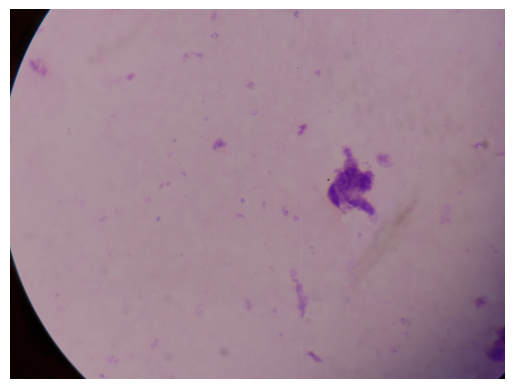

In [ ]:
img = mpimg.imread("id_rcmgx74i4g.jpg")
imgplot = plt.imshow(img)
plt.axis('off')

(-0.5, 1919.5, 1079.5, -0.5)

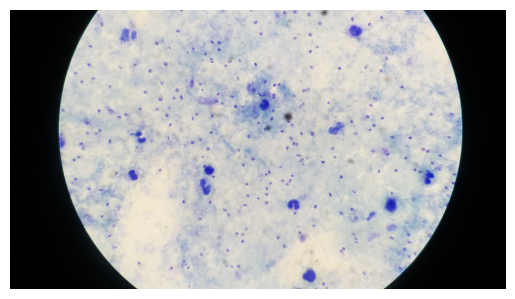

In [ ]:
img = mpimg.imread("id_mzq1jmom69.jpg")
imgplot = plt.imshow(img)
plt.axis('off')

# **3. Limpieza de Datos**

___

## A. Eliminar Datos con más de 2 Clases Asignadas

In [ ]:
multiple_classes_df = aggregated_df[aggregated_df["NumberClasses"] > 1]
multiple_classes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1542 entries, 0 to 2745
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_ID       1542 non-null   object
 1   NumberClasses  1542 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.1+ KB


In [ ]:
valid_df = df[~df["Image_ID"].isin(multiple_classes_df["Image_ID"].tolist())]
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3349 entries, 2 to 23528
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    3349 non-null   object 
 1   class       3349 non-null   object 
 2   confidence  3349 non-null   float64
 3   ymin        3349 non-null   int64  
 4   xmin        3349 non-null   int64  
 5   ymax        3349 non-null   int64  
 6   xmax        3349 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 209.3+ KB


Cantidad de datos eliminados

In [ ]:
print("Número de datos originales: {}".format(len(df)))
print("Número de datos después del filtrado: {}".format(len(valid_df)))

Número de datos originales: 23530
Número de datos después del filtrado: 3349


Aún hay una diferencia en la cantidad de las clases, pero no puedo aumentar datos para las clases NEG y WBC, porque no tengo mucho espacio en Google Drive.

Lo correcto sería aumentar la cantidad de datos para que estén a cantidades similares, pero lo que haré será balancear la cantidad de datos por clase.

In [ ]:
valid_df["class"].value_counts()

,count
class,
Trophozoite,2239
NEG,688
WBC,422


## B. Eliminar Imágenes que Aparecen Múltiples Veces (NO SE USARÁ EL DATAFRAME RESULTANTE)

Hay mismas imágenes que aparecen más de 1 vez en el datset

In [ ]:
grouped_valid_df = valid_df.groupby("Image_ID").size().reset_index(name = "Count")
grouped_valid_df.head(5)

,Image_ID,Count
0,id_00m1onu6hj.jpg,1
1,id_00n92f65ke.jpg,1
2,id_013o32svbt.jpg,1
3,id_05do1czfb1.jpg,2
4,id_06xcou9044.jpg,2


In [ ]:
cleaned_df = valid_df[~valid_df["Image_ID"].isin(grouped_valid_df[grouped_valid_df["Count"] > 1]["Image_ID"])]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 735 entries, 4 to 23502
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    735 non-null    object 
 1   class       735 non-null    object 
 2   confidence  735 non-null    float64
 3   ymin        735 non-null    int64  
 4   xmin        735 non-null    int64  
 5   ymax        735 non-null    int64  
 6   xmax        735 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 45.9+ KB


Son muy pocos datos los que resultaron, no creo que trabaje con estos datos!!!

In [ ]:
cleaned_df["class"].value_counts()

,count
class,
NEG,688
Trophozoite,44
WBC,3


# **4. Preprocesamiento de Datos**

___

## A. Balancear los Datos de las Clases

In [ ]:
balanced_df = valid_df.groupby("class").apply(lambda x : x.sample(n = 422, random_state = 400))
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1266 entries, ('NEG', 2187) to ('WBC', 19308)
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    1266 non-null   object 
 1   class       1266 non-null   object 
 2   confidence  1266 non-null   float64
 3   ymin        1266 non-null   int64  
 4   xmin        1266 non-null   int64  
 5   ymax        1266 non-null   int64  
 6   xmax        1266 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 115.3+ KB


<ipython-input-21-73e078f90bc7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = valid_df.groupby("class").apply(lambda x : x.sample(n = 422, random_state = 400))


## B. Dividir en datos de Test, Train y Validation

In [ ]:
train_data, val_data = train_test_split(balanced_df, test_size = 0.25, random_state = 900, stratify = balanced_df["class"])
total = len(train_data) + len(val_data) + len(test_data)
print("Cantidad de datos para entrenamiento son {} ({}%), para validación son {} ({}%) y de test son {} ({}%).".format(
    len(train_data), round(len(train_data) / total * 100, 3),
    len(val_data), round(len(val_data) / total * 100, 3),
    len(test_data), round(len(test_data) / total * 100, 3)
    )
)

Cantidad de datos para entrenamiento son 949 (38.83%), para validación son 317 (12.971%) y de test son 1178 (48.2%).


## C. Aumentar y Normalizar los Datos

Normalizar los valores de cada pixel y alterar algunas imágenes del train

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 35,
    zoom_range = 0.15,
    channel_shift_range = 2.0,
    vertical_flip = True,
    horizontal_flip = True,
    fill_mode = "constant"
)

val_datagen = ImageDataGenerator(rescale = 1 / 255)
test_datagen = ImageDataGenerator(rescale = 1 / 255)

Convertir las imágenes a escala de grises y a un tamaño igual

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = "/content/drive/My Drive/Datasets/Malaria/images/",
    x_col = "Image_ID",
    y_col = "class",
    target_size = (260, 260),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale",
    shuffle = False
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = "/content/drive/My Drive/Datasets/Malaria/images/",
    x_col = "Image_ID",
    y_col = "class",
    target_size = (260, 260),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale",
    shuffle = False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = "/content/drive/My Drive/Datasets/Malaria/images/",
    x_col = "Image_ID",
    target_size = (260, 260),
    batch_size = 32,
    class_mode = None,
    color_mode = "grayscale",
    shuffle = False
)

Found 949 validated image filenames belonging to 3 classes.
Found 317 validated image filenames belonging to 3 classes.
Found 1178 validated image filenames.


Verificar que estén bien balanceados

In [ ]:
print("Cantidad de clases : {}".format(len(train_generator.class_indices)))

print("\nDistribución de clases en el conjunto en entrenamiento:\n")
print(train_data['class'].value_counts(normalize=True))
print("\nDistribución de clases en el conjunto en validación:\n")
print(val_data['class'].value_counts(normalize=True))

Cantidad de clases : 3

Distribución de clases en el conjunto en entrenamiento:

class
NEG            0.334036
Trophozoite    0.332982
WBC            0.332982
Name: proportion, dtype: float64

Distribución de clases en el conjunto en validación:

class
Trophozoite    0.334385
WBC            0.334385
NEG            0.331230
Name: proportion, dtype: float64


## D. Visualización de Imágenes

Esta parte del código no es mía, me ayudó muchísimo en el tiempo

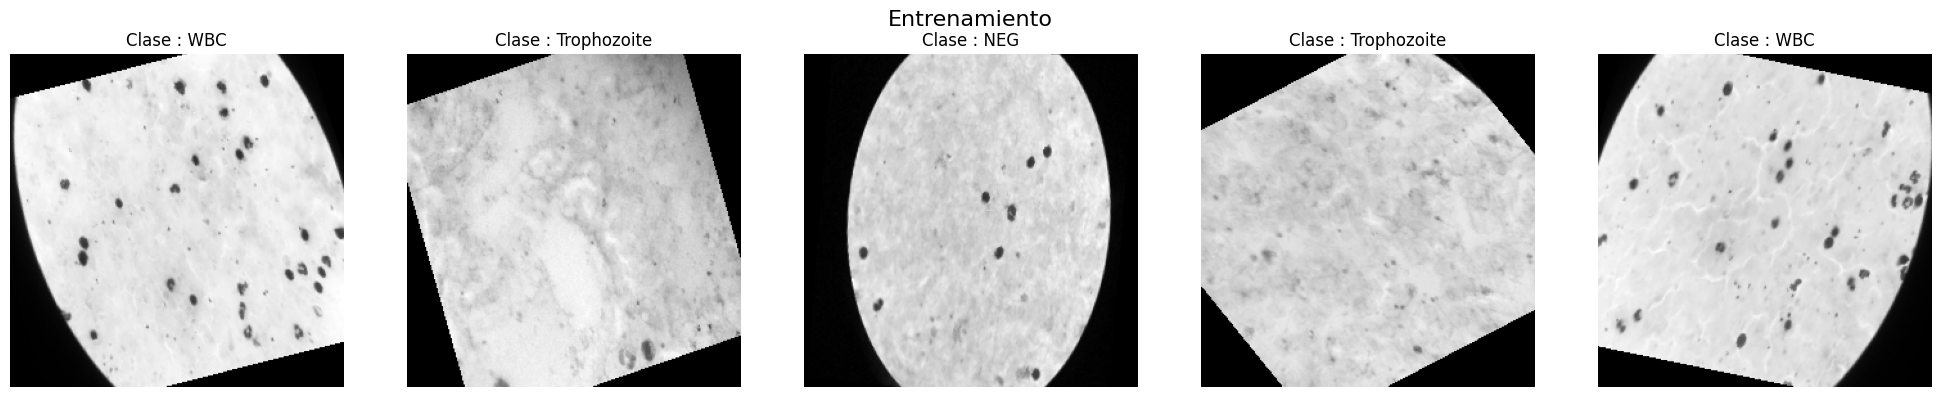

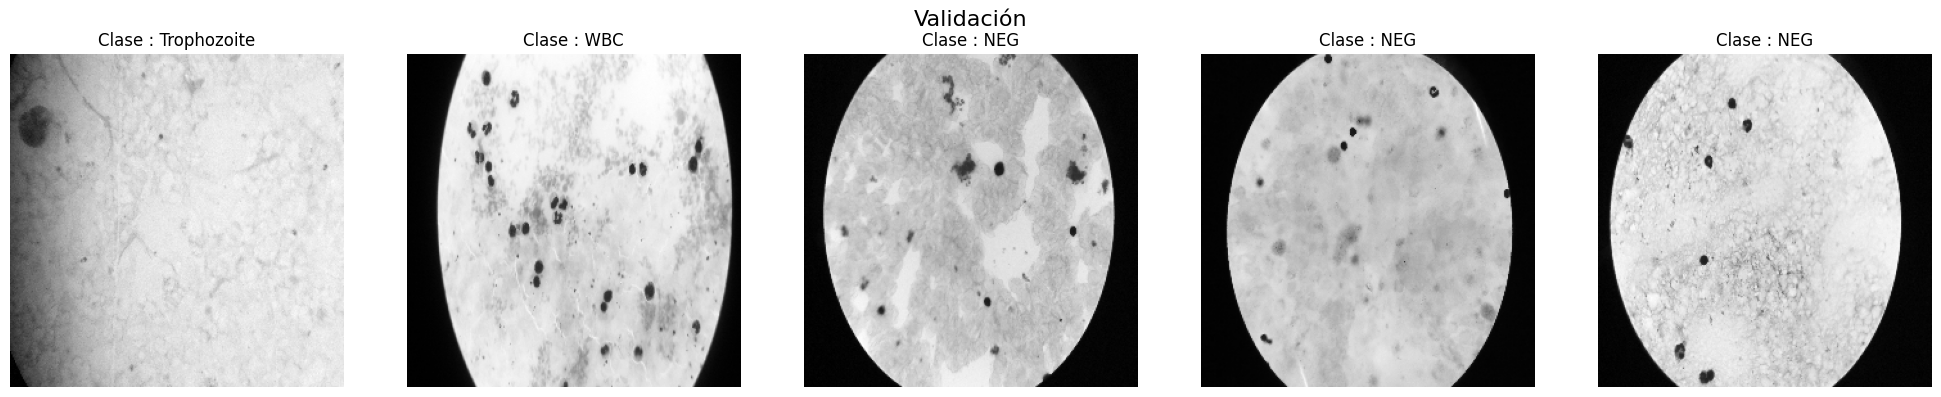

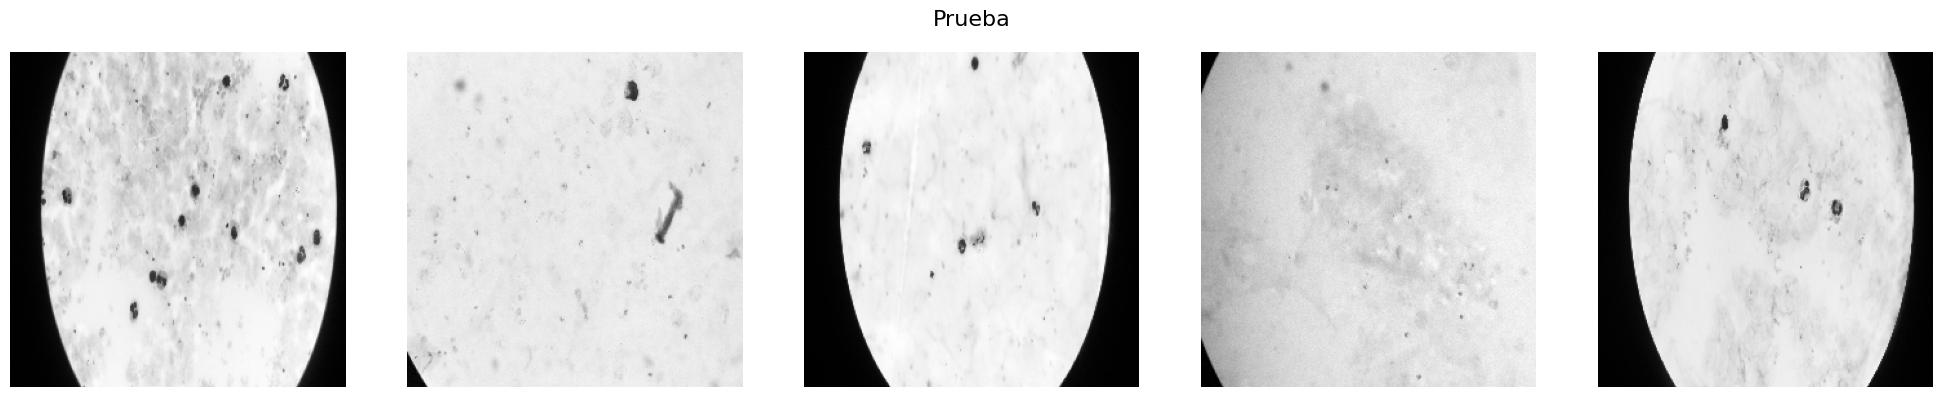

In [ ]:
def show_images(generator, title, n = 5):
    plt.figure(figsize = (20, 4))
    plt.suptitle(title, fontsize = 16)

    has_classes = hasattr(generator, "class_indices")

    if has_classes:
        class_indices = generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}

    for i in range(n):
        batch = next(generator)

        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch

        idx = np.random.randint(0, images.shape[0])
        img = images[idx]

        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze(), cmap = "gray")
        plt.axis("off")

        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title("Clase : {}".format(class_name))

    plt.tight_layout()
    plt.show()

show_images(train_generator, "Entrenamiento")
show_images(val_generator, "Validación")
show_images(test_generator, "Prueba")

# **5. Arquitectura de Red Neuronal Convolucional (CNN)**

___

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (260, 260, 1), activation = "relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(10, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 258, 258, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 129, 129, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 129, 129, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 61, 61, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         921,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 959,275 (3.66 MB)

 Trainable params: 959,275 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

# **6. Entrenar Red Neuronal**

___

In [ ]:
history = model.fit(train_generator, epochs = 20, verbose = 2, validation_data = val_generator)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 - 241s - 8s/step - accuracy: 0.3846 - loss: 1.1196 - val_accuracy: 0.3880 - val_loss: 0.9842
Epoch 2/20
30/30 - 219s - 7s/step - accuracy: 0.5026 - loss: 0.9594 - val_accuracy: 0.9558 - val_loss: 0.7206
Epoch 3/20
30/30 - 214s - 7s/step - accuracy: 0.5911 - loss: 0.8612 - val_accuracy: 0.6972 - val_loss: 0.7421
Epoch 4/20
30/30 - 217s - 7s/step - accuracy: 0.6765 - loss: 0.7423 - val_accuracy: 0.8233 - val_loss: 0.6458
Epoch 5/20
30/30 - 209s - 7s/step - accuracy: 0.7155 - loss: 0.6412 - val_accuracy: 0.8801 - val_loss: 0.5706
Epoch 6/20
30/30 - 260s - 9s/step - accuracy: 0.7734 - loss: 0.5194 - val_accuracy: 0.8580 - val_loss: 0.3946
Epoch 7/20
30/30 - 209s - 7s/step - accuracy: 0.8135 - loss: 0.4296 - val_accuracy: 0.8612 - val_loss: 0.4040
Epoch 8/20
30/30 - 211s - 7s/step - accuracy: 0.7713 - loss: 0.5853 - val_accuracy: 0.7161 - val_loss: 0.6333
Epoch 9/20
30/30 - 259s - 9s/step - accuracy: 0.8240 - loss: 0.4103 - val_accuracy: 0.8139 - val_loss: 0.4816
Epoch 10/20
30/30 - 2

# **7. Evaluar el Modelo**

---

## A. Gráfica de Loss y Accuracy

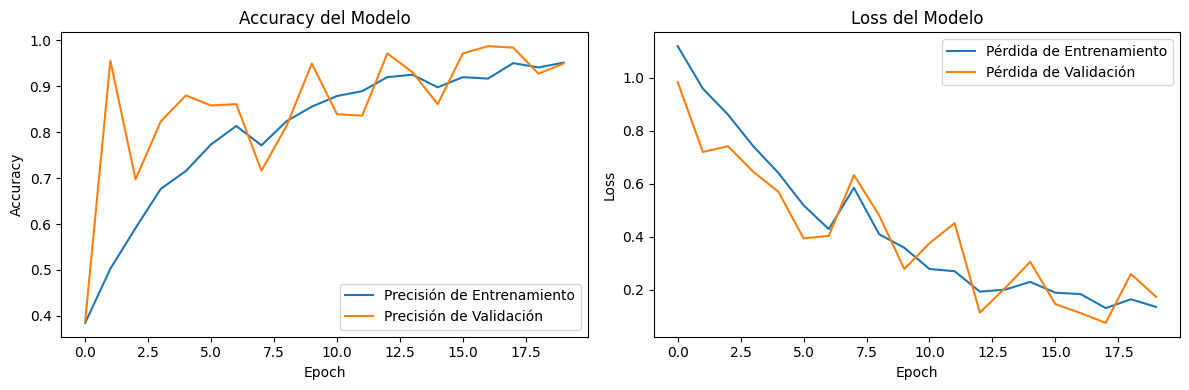

In [ ]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "Precisión de Entrenamiento")
plt.plot(history.history["val_accuracy"], label = "Precisión de Validación")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy del Modelo")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label = "Pérdida de Validación")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss del Modelo")
plt.legend()

plt.tight_layout()
plt.show()

## B. Calcular 'Accuracy', 'Precision', 'Recall' y 'F1-Score'

Predecir con el modelo entrenado los datos de train y validation

Para este paso cambié el parámetro shuffler a False de los generadores para que me dieran los verdaderos resultados

In [ ]:
train_predictions = model.predict(train_generator)
val_predictions = model.predict(val_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step


In [ ]:
train_predicted_classes = np.argmax(train_predictions, axis = 1)
val_predicted_classes = np.argmax(val_predictions, axis = 1)

Obtener las verdaderas etiquetas de los datos

In [ ]:
train_true_labels = train_generator.classes
val_true_labels = val_generator.classes

Mostrar las diferentes métricas

In [ ]:
f1 = f1_score(val_true_labels, val_predicted_classes, average = "weighted")
accuracy = accuracy_score(val_true_labels, val_predicted_classes)
recall = recall_score(val_true_labels, val_predicted_classes, average = "weighted")
precision = precision_score(val_true_labels, val_predicted_classes, average = "weighted")

print("Accuracy: {}".format(round(accuracy, 5)))
print("F1-Score: {}".format(round(f1, 5)))
print("Recall: {}".format(round(recall, 5)))
print("Precision: {}".format(round(precision, 5)))

Accuracy: 0.94953
F1-Score: 0.94944
Recall: 0.94953
Precision: 0.95282


## C. Matriz de Confusión

In [ ]:
classes = list(train_generator.class_indices.keys())

Graficar la matriz de confusión para los datos de train y validation

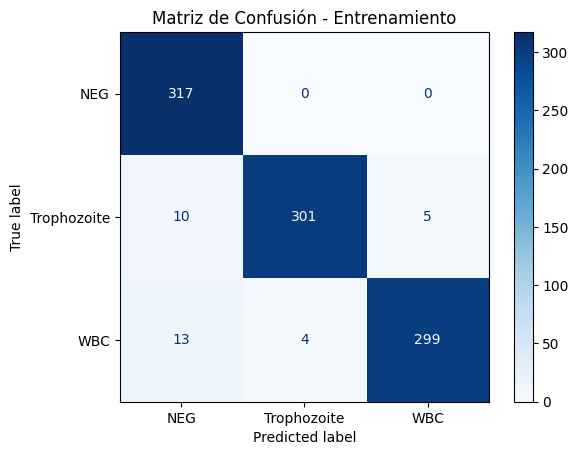

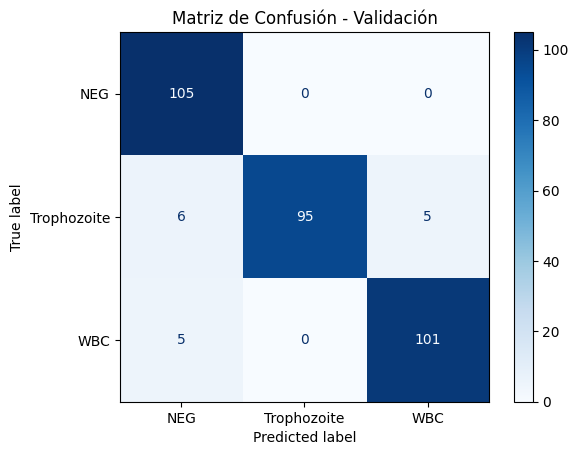

In [ ]:
train_cm = confusion_matrix(train_true_labels, train_predicted_classes)
train_disp = ConfusionMatrixDisplay(confusion_matrix = train_cm, display_labels = classes)
train_disp.plot(cmap = plt.cm.Blues)
plt.title("Matriz de Confusión - Entrenamiento")
plt.show()

val_cm = confusion_matrix(val_true_labels, val_predicted_classes)
val_disp = ConfusionMatrixDisplay(confusion_matrix = val_cm, display_labels = classes)
val_disp.plot(cmap = plt.cm.Blues)
plt.title("Matriz de Confusión - Validación")
plt.show()

# **8. Probar con los Datos de Test**

___

## A. Predecir los Datos de Test

In [ ]:
predictions = model.predict(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step


In [ ]:
classes = list(train_generator.class_indices.keys())

## B. Colocar las Clases al DataFrame

In [ ]:
final_df = pd.DataFrame({
    "Image_ID": test_data["Image_ID"],
    "Predicted_Class": [classes[np.argmax(pred)] for pred in predictions],
    "Confidence": [str(round(np.max(pred) * 100, 3)) + " %" for pred in predictions]
})

In [ ]:
final_df.head(10)

,Image_ID,Predicted_Class,Confidence
0,id_5n9ov0rr22.jpg,WBC,71.699 %
1,id_k6s11k3klo.jpg,Trophozoite,96.544 %
2,id_eftvcf9djb.jpg,WBC,60.059 %
3,id_kc5tmoj1xa.jpg,WBC,56.908 %
4,id_tirid4qt68.jpg,Trophozoite,69.051 %
5,id_9n3y98f17z.jpg,Trophozoite,84.656 %
6,id_nqpnemu007.jpg,NEG,100.0 %
7,id_5h9byqfx7x.jpg,NEG,95.944 %
8,id_dmomjbyr9c.jpg,WBC,93.995 %
9,id_40f6rz7r0m.jpg,WBC,84.043 %
